In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import sys
import os
sys.path.append(os.path.abspath('../..'))
from project_paths import PROJECT_ROOT
from functions import get_params_string
from file_handler import VarHandler
from Paper.figure_scripts import common

In [3]:
L = 16
n_dim = 1
PBC = True
model_label = "TFIM"
hs = np.arange(0.5, 10, 0.5)
model_params = lambda x: {"J": 1, "h": x}
N_therm = 2 ** np.arange(10, 20)

folder = f"{PROJECT_ROOT}Data/LPSE/Noisy_rbm/Acceptance/"
sigmas = np.concatenate(([0], np.logspace(-3, 3, 100))) 

In [4]:
import netket as nk

g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(1/2, g.n_nodes)
states = hi.all_states()
model = nk.models.RBM()

log_pdf_std = []

for h in hs:
    var = VarHandler(f"{PROJECT_ROOT}Data/Parameters/MC/", model_label, "RBM_alpha1", L, PBC, n_dim, **model_params(h))
    vs = nk.vqs.FullSumState(hi, model)
    vs.variables = var.load_variables(vs.variables)
    log_pdf = model.apply(vs.variables, states) * 2
    log_pdf_std.append(np.std(log_pdf))

/Users/som30090/cpu_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
acceptance = np.zeros((len(hs), len(sigmas)))

for m, h in enumerate(hs):
    params_str = get_params_string(model_params(h))
    df = pd.read_csv(f"{folder}{model_label}{params_str}_L{L}_{n_dim}dim.csv")
    mask = df["Sigma"].apply(lambda x: np.any(np.isclose(x, sigmas, rtol=1e-2)))
    df = df[mask].sort_values(by="Sigma")
    acceptance[m, :] = df["Acceptance"].to_numpy()

In [6]:
folder = f"{PROJECT_ROOT}Data/LPSE/Ratio/"
ratio_mean = []
ratio_error = []
ratio_median = []

for h in hs:
    param_str = get_params_string({"J": 1, "h": h})
    df = pd.read_csv(f"{folder}{model_label}{param_str}_RBM_alpha1_L{L}_{n_dim}dim.csv")
    r = df["Ratio"].to_numpy()
    ratio_mean.append(np.mean(r))
    ratio_error.append(np.std(r))
    ratio_median.append(np.median(r))

ratio_mean = np.array(ratio_mean).reshape((len(hs), -1))
ratio_error = np.array(ratio_error).reshape((len(hs), -1))
ratio_median = np.array(ratio_median).reshape((len(hs), -1))

/var/folders/s_/rrthff591dgbgx9_kr8gwhfm0000gp/T/ipykernel_2316/3978689998.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


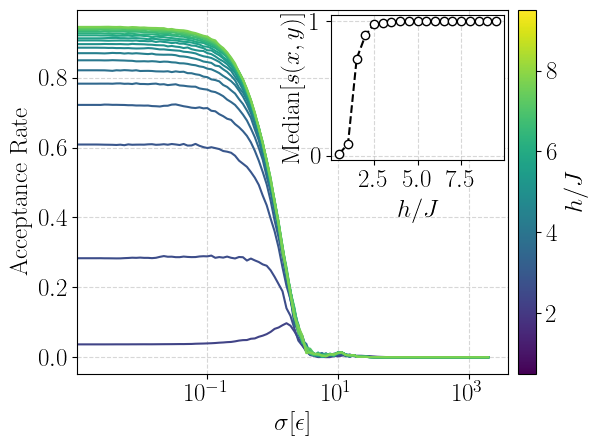

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors = cm.viridis(np.linspace(0.2, 0.8, len(hs)))
norm = mcolors.Normalize(vmin=min(hs), vmax=max(hs))
sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)

fig, ax1 = plt.subplots()

for i, h in enumerate(hs):
    ax1.plot(sigmas * 2, acceptance[i], ls="-", color=colors[i])

ax1.set_xscale("log")
# ax1.set_yscale("log")
ax1.set_ylabel("Acceptance Rate")
ax1.set_xlabel(r"$\sigma[\epsilon]$")
ax1.grid(ls="--", alpha=0.5)
# ax1.set_xlim(1e-3, 1e2)

cbar = plt.colorbar(sm, ax=ax1, pad=0.02)
cbar.set_label(r"$h/J$")

# --- Inset plot (top-right of main plot) ---
ax_inset = inset_axes(ax1, width="100%", height="100%", 
                      bbox_to_anchor=(0.61, 0.61, 0.4, 0.4), 
                      bbox_transform=ax1.transAxes)
ax_inset.plot(hs, ratio_median, marker="o", ls="--", color="black", markerfacecolor="white", markeredgecolor="black")
ax_inset.set_xlabel(r"$h/J$")
ax_inset.set_ylabel(r"Median$[s(x,y)]$")
ax_inset.grid(ls="--", alpha=0.5)
ax_inset.tick_params(axis='both', which='major')

plt.tight_layout()
plt.savefig("figures/acceptance_noisyRBM_inset.pdf")
plt.show()